# Convolutions by examples
_From [Dataflowr Module 6](https://dataflowr.github.io/website/modules/6-convolutional-neural-network/) by Marc Lelarge_

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision

## MNIST dataset

MNIST is the classic dataset of 28x28 grayscale images of handwritten digits (0-9) that we used in TP-1. It contains:
- 60,000 training images
- 10,000 test images

We can use PyTorch to download and create a dataloader for MNIST.


In [2]:
root_dir = "./data/MNIST/"
torchvision.datasets.MNIST(root=root_dir, download=True)
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)
MNIST_dataset = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True, num_workers=1
)

We can then renormalize the gray scale values to [0, 1] and store the labels

In [3]:
images = train_set.data.float() / 255
labels = train_set.targets

In [4]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    if isinstance(ims, torch.Tensor):
        ims = ims.cpu().numpy()
    elif isinstance(ims, list) and len(ims) > 0 and isinstance(ims[0], torch.Tensor):
        ims = torch.stack(ims).cpu().numpy()
    mn, mx = ims.min(), ims.max()
    f = plt.figure(figsize=(12, 24))
    for i in range(len(ims)):
        sp = f.add_subplot(1, len(ims), i + 1)
        if not titles is None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else "none", vmin=mn, vmax=mx)


# plot a single image
def plot(im, interp=False):
    if isinstance(im, torch.Tensor):
        im = im.cpu().numpy()
    f = plt.figure(figsize=(3, 6), frameon=True)
    plt.imshow(im, interpolation=None if interp else "none")


plt.gray()
plt.close()

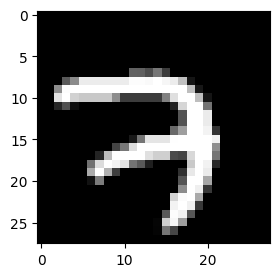

In [5]:
plot(images[5000])

In [6]:
labels[5000]

tensor(7)

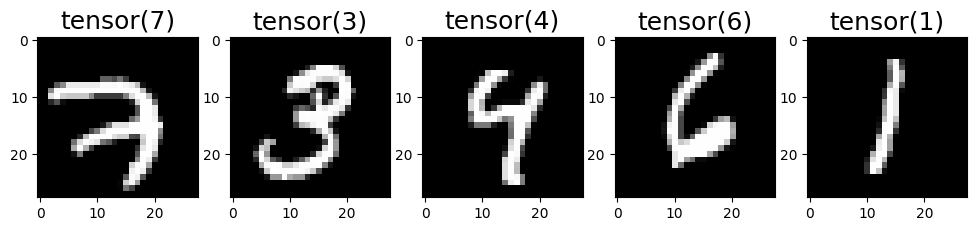

In [7]:
plots(images[5000:5005], titles=labels[5000:5005])

## Baseline: A simple 1 vs 8 classifier

In this section we will construct a basic binary classifier that distinguishes between ones and eights.

We fetch all images from the _eight_ class and from the _one_ class.

In [8]:
eights = torch.stack([i for (i, l) in zip(images, labels) if l == 8])
ones = torch.stack([i for (i, l) in zip(images, labels) if l == 1])

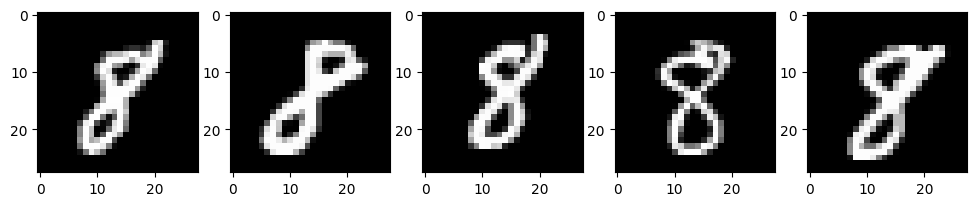

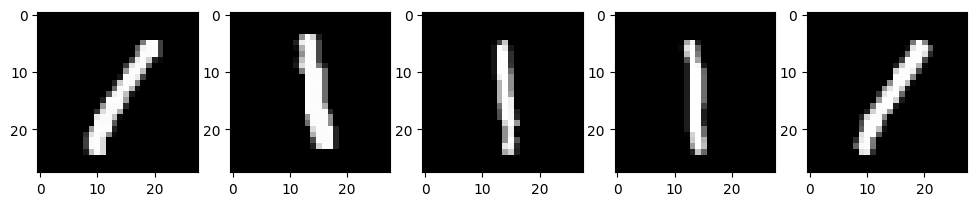

In [9]:
plots(eights[:5])
plots(ones[:5])

We keep the first 1000 digits for the test set and average all the remaining digits.

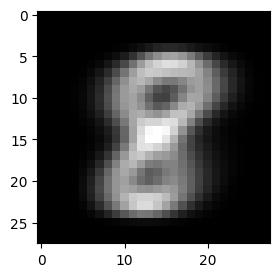

In [10]:
test8, train8 = eights[:1000], eights[1000:]

raws8 = train8.mean(dim=0)

plot(raws8)

We now do the same thing with the ones:

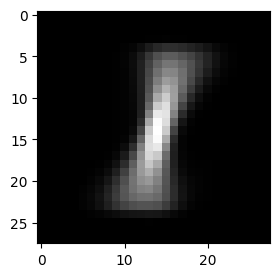

In [11]:
test1, train1 = ones[:1000], ones[1000:]

raws1 = ones[1000:].mean(dim=0)

plot(raws1)

We built a 'typical representative' of the eights and a 'typical representative' of the ones. Now for a new sample from the test set, we compute the distance between this sample and our two representatives and classify the sample with the label of the closest representative.

For the distance between images, we just take the pixelwise squared distance.

In [12]:
# sum of squared distance
def sse(a, b):
    return ((a - b) ** 2).sum()


# return 1 if closest to 8 and 0 otherwise
def is8_raw_n2(im):
    return 1 if sse(im, raws1) > sse(im, raws8) else 0

Now let's look at the results.

In [13]:
nb_8_predicted_8 = sum([is8_raw_n2(im) for im in test8])
nb_1_predicted_8 = sum([is8_raw_n2(im) for im in test1])
nb_8_predicted_1 = sum([(1 - is8_raw_n2(im)) for im in test8])
nb_1_predicted_1 = sum([(1 - is8_raw_n2(im)) for im in test1])

# just to check
print(nb_8_predicted_1 + nb_8_predicted_8, nb_1_predicted_1 + nb_1_predicted_8)

1000 1000


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png" alt="Drawing" style="width: 500px;"/>

source [wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

In [14]:
def compute_scores(
    nb_8_predicted_8, nb_8_predicted_1, nb_1_predicted_1, nb_1_predicted_8
):
    Precision_8 = nb_8_predicted_8 / (nb_8_predicted_8 + nb_1_predicted_8)
    Recall_8 = nb_8_predicted_8 / (nb_8_predicted_1 + nb_8_predicted_8)
    Precision_1 = nb_1_predicted_1 / (nb_1_predicted_1 + nb_8_predicted_1)
    Recall_1 = nb_1_predicted_1 / (nb_1_predicted_1 + nb_1_predicted_8)
    return Precision_8, Recall_8, Precision_1, Recall_1


Precision_8, Recall_8, Precision_1, Recall_1 = compute_scores(
    nb_8_predicted_8, nb_8_predicted_1, nb_1_predicted_1, nb_1_predicted_8
)

print("precision 8:", Precision_8, "recall 8:", Recall_8)
print("precision 1:", Precision_1, "recall 1:", Recall_1)
print("accuracy :", (Recall_1 + Recall_8) / 2)

precision 8: 0.9712460063897763 recall 8: 0.912
precision 1: 0.9170593779453345 recall 1: 0.973
accuracy : 0.9425


This is our baseline for our binary classification task. Now your task will be to do better with convolutions!

## Filters and convolutions

Let's start with this visual explanation: [Interactive image kernels](http://setosa.io/ev/image-kernels/)

In practice, we slide the filter matrix over the image (a larger matrix), always selecting patches from the image with the same size as the filter. We compute the dot product between the filter and the image patch and store the scalar response, which reflects the degree of similarity/correlation between the filter and the image patch.

### Conv2D

In PyTorch, the [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) operator implements convolution, but it expects input of shape `[batch, channels, height, width]`. Here we have grayscale images (1 channel) that we process one at a time (batch size 1) and we use `unsqueeze` to add the missing dimensions.

In [15]:
import torch.nn.functional as F


# We need to add batch and channel dimensions for conv2d
def conv2d(image, kernel, padding=1):
    # Add batch and channel dimensions
    img = image.unsqueeze(0).unsqueeze(0)
    kern = kernel.unsqueeze(0).unsqueeze(0)
    result = F.conv2d(img, kern, padding=padding)
    return result.squeeze()  # remove batch dim

Here is a simple 3×3 filter, i.e., a 3×3 matrix (see [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples):

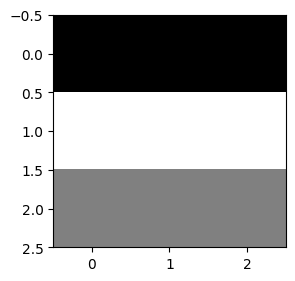

In [16]:
top = torch.tensor([[-1, -1, -1], [1, 1, 1], [0, 0, 0]], dtype=torch.float32)

plot(top)

We now create a toy image to understand how convolutions operate.

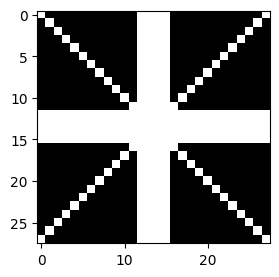

In [17]:
cross = torch.zeros((28, 28))
cross += torch.eye(28)
cross += torch.fliplr(torch.eye(28))
for i in range(4):
    cross[12 + i, :] = torch.ones(28)
    cross[:, 12 + i] = torch.ones(28)

plot(cross)

Our `top` filter should highlight the top horizontal border in the image.

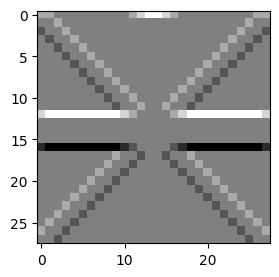

In [18]:
corr_cross = conv2d(cross, top)

plot(corr_cross)

### Padding and stride

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>

source: [Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

torch.Size([30, 30])


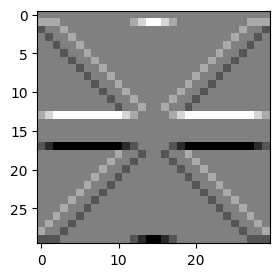

In [19]:
# to see the role of padding
corr_cross = conv2d(cross, top, padding=2)
plot(corr_cross)
print(corr_cross.shape)

Now let's try on a real image...

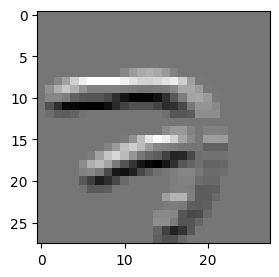

In [20]:
corrtop = conv2d(images[5000], top)
plot(corrtop)

### Filter bank

Let's generate a few more variants of our simple 3×3 filter:

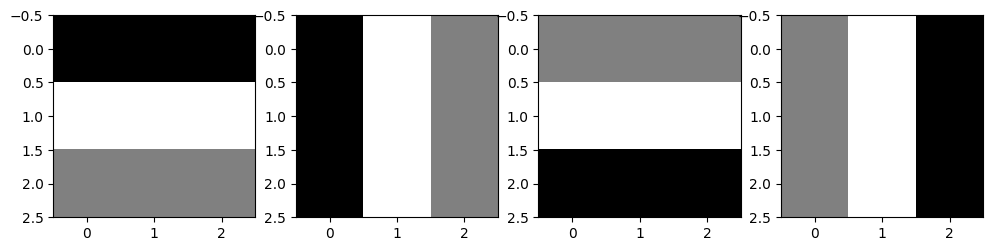

In [21]:
straights = [torch.rot90(top, i) for i in range(4)]
plots(straights)

We proceed similarly to generate a set of filters with different behavior:

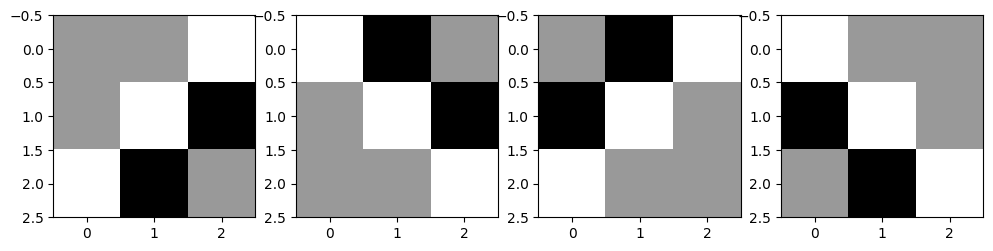

In [22]:
br = torch.tensor([[0, 0, 1], [0, 1, -1.5], [1, -1.5, 0]], dtype=torch.float32)

diags = [torch.rot90(br, i) for i in range(4)]
plots(diags)

We can compose filters to obtain more complex patterns

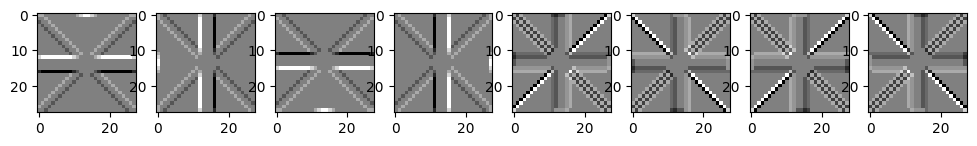

In [23]:
rots = straights + diags
corrs = [conv2d(cross, rot) for rot in rots]
plots(corrs)

Let's try again on an actual image:

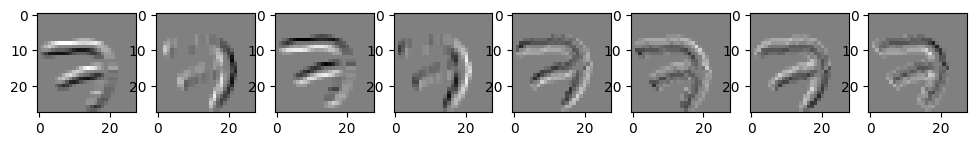

In [24]:
rots = straights + diags
corrs = [conv2d(images[5000], rot) for rot in rots]
plots(corrs)

### Max pooling

Next, we illustrate the effect of downsampling.

We select the most basic downsampling technique: **max pooling**. We keep only the maximum value for sliding windows of size 7×7. The animation is similar to the stride version of the convolution (see above), but we take the max instead of the dot product.

**Max pooling** is a handy technique with a few useful properties:
- Since it selects the maximum values, it ensures invariance to small translations
- Reducing the size is helpful since data becomes more compact and easier to compare
- Since max pooling reduces the size of our images, operations performed later in the network have a bigger receptive field (i.e., they concern a bigger patch in the input image) and allow the discovery of higher-level patterns.

In PyTorch, the [max_pool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) operator implements the max pooling, but as for conv2d, it expects input of shape `[batch, channels, height, width]`. Here we have grayscale images (1 channel) that we process one at a time (batch size 1) and we use `unsqueeze` to add the missing dimensions.

With `kernel_size=7` and `stride=7`, we use non-overlapping 7×7 windows where each outputs the maximum value, downsampling our 28×28 images to 4×4.

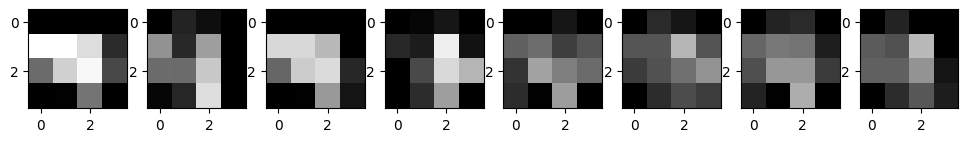

In [25]:
# Max pooling with PyTorch
def pool(im):
    # Add batch and channel dimensions
    img = im.unsqueeze(0).unsqueeze(0)
    # Apply max pooling with kernel size 7
    result = F.max_pool2d(img, kernel_size=7, stride=7)
    return result.squeeze()


plots([pool(im) for im in corrs])

### Back to the 1 vs 8 classifier

We can now build a classifier with convolutions.

We convolve the training set with our set of filters, pool them, and average them for each class and filter. We will thus obtain a set of _representative_ signatures for _eights_ and for _ones_. 

Given a new test image, we compute its features by convolution and pooling with the same filters, then compare them with the _representative_ features. The class with the most similar features is chosen as the prediction.

Let's define a function that correlates a given image with all filters from `rots` and max pools the responses:

In [26]:
def pool_corr(im):
    return torch.stack([pool(conv2d(im, rot)) for rot in rots])

We can now convolve the training images of _eights_ with our bank of filters, perform max pooling on the responses, and store them in `pool8`.

In [27]:
pool8 = torch.stack([pool_corr(im) for im in train8])

In [28]:
pool8.shape

torch.Size([4851, 8, 4, 4])

We plot the result of the first filter+pooling on the first 5 _eights_ in our set:

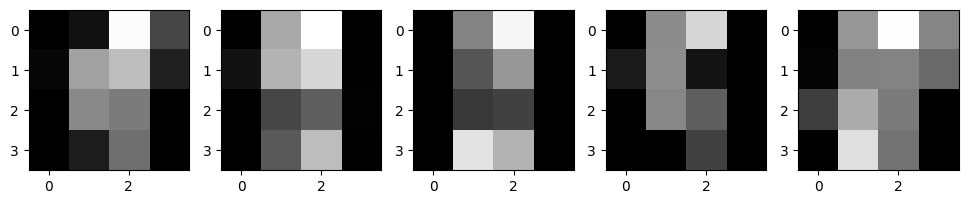

In [29]:
plots(pool8[0:5, 0])

For the first 4 _eights_ in our set, we plot the result of the 8 filters+pooling:

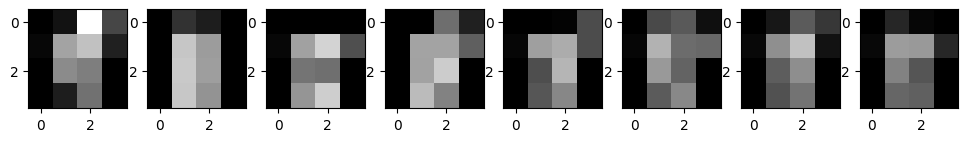

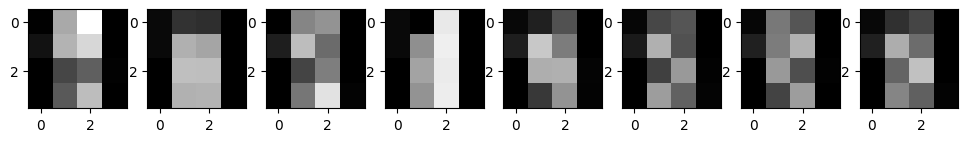

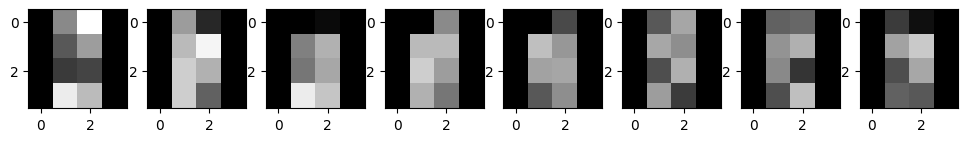

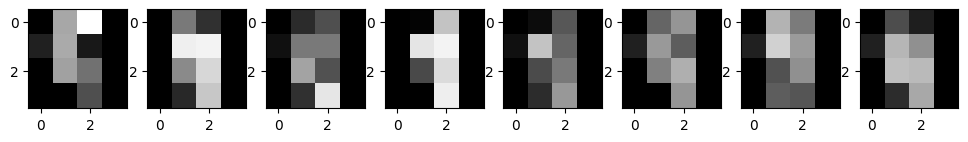

In [30]:
plots([pool8[0, i] for i in range(8)])
plots([pool8[1, i] for i in range(8)])
plots([pool8[2, i] for i in range(8)])
plots([pool8[3, i] for i in range(8)])

We normalize the data in order to smooth activations and bring them to similar ranges of values:

In [31]:
def normalize(arr):
    return (arr - arr.mean()) / arr.std()

Next, we compute the average _eight_ by averaging all responses for each filter from `rots`.

In [32]:
filts8 = pool8.mean(dim=0)
filts8 = normalize(filts8)

We should obtain a set of canonical _eights_ responses for each filter.

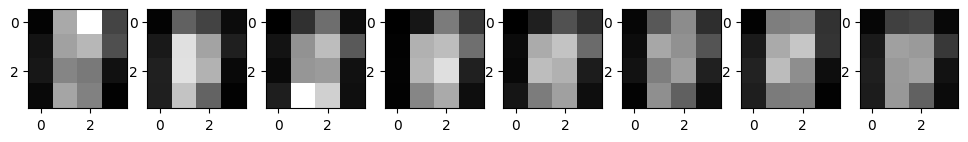

In [33]:
plots(filts8)

We proceed similarly with training samples from the _one_ class and plot the canonical _ones_.

In [34]:
pool1 = torch.stack([pool_corr(im) for im in train1])
filts1 = pool1.mean(dim=0)
filts1 = normalize(filts1)

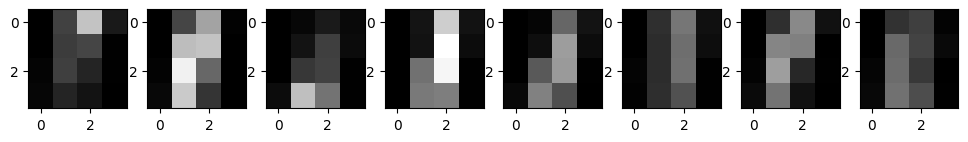

In [35]:
plots(filts1)

Do you notice any differences between `filts8` and `filts1`? Which ones?

Now we can classify an image by computing `pool_corr` and returning the label of the closest representative.

In [36]:
# is8_n2 returns 1 if it thinks it's an eight and 0 otherwise
def is8_n2(im):
    return 1 if sse(pool_corr(im), filts1) > sse(pool_corr(im), filts8) else 0

We perform a check to see if our function actually works. We correlate an image of _eight_ with `filts8` and `filts1`. It should give a smaller distance for the _eights_:

In [37]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(tensor(103.2760), tensor(125.6145))

In [38]:
is8_n2(eights[0]), is8_n2(ones[0])

(1, 0)

We can now test our classifier on 1000 images of _eights_ and 1000 images of _ones_ in the test set:

In [39]:
nb_8_predicted_8 = sum([is8_n2(im) for im in test8])
nb_1_predicted_8 = sum([is8_n2(im) for im in test1])
nb_8_predicted_1 = sum([(1 - is8_n2(im)) for im in test8])
nb_1_predicted_1 = sum([(1 - is8_n2(im)) for im in test1])

# just to check
print(nb_8_predicted_1 + nb_8_predicted_8, nb_1_predicted_1 + nb_1_predicted_8)

1000 1000


In [40]:
Precisionf_8, Recallf_8, Precisionf_1, Recallf_1 = compute_scores(
    nb_8_predicted_8, nb_8_predicted_1, nb_1_predicted_1, nb_1_predicted_8
)

print("precision 8:", Precisionf_8, "recall 8:", Recallf_8)
print("precision 1:", Precisionf_1, "recall 1:", Recallf_1)
print("accuracy :", (Recallf_1 + Recallf_8) / 2)
print("accuracy baseline:", (Recall_1 + Recall_8) / 2)

precision 8: 0.963220675944334 recall 8: 0.969
precision 1: 0.9688128772635815 recall 1: 0.963
accuracy : 0.966
accuracy baseline: 0.9425


We improved the accuracy while reducing the embedding size from a 28×28 = 784 dimensional vector to a 4×4×8 = 128 dimensional vector.

We have successfully built a classifier for _eights_ and _ones_ using features extracted with a bank of predefined filters and a set of training samples.

Now, can you do better by automatically learning the filters?